# **Machine Learning with Python: Zero to GBMs Course Project**

# **Home Credit Default Risk** `[Kaggle Competition]`

## Installing Required Packages

In [ ]:
!pip install numpy pandas matplotlib seaborn kaggle scikit-learn imblearn lightgbm xgboost -q

## Importing Required Libraries

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, roc_curve, log_loss, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

## Kaggle Setup

**Upload Kaggle Credential File (kaggle.json)**

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shubamsumbria","key":"88eaf012a58d710e4ec37da303a73945"}'}

In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

## Data Loading







**Downloading Data**

In [ ]:
!kaggle competitions download home-credit-default-risk -q

**Unzipping All Files**

In [ ]:
!rm -r /content/hcdr-data
!mkdir /content/hcdr-data
!unzip "/content/application_train.csv.zip" -d "/content/hcdr-data"
!unzip "/content/application_test.csv.zip" -d "/content/hcdr-data"
!unzip "/content/bureau.csv.zip" -d "/content/hcdr-data"
!unzip "/content/bureau_balance.csv.zip" -d "/content/hcdr-data"
!unzip "/content/credit_card_balance.csv.zip" -d "/content/hcdr-data"
!unzip "/content/installments_payments.csv.zip" -d "/content/hcdr-data"
!unzip "/content/previous_application.csv.zip" -d "/content/hcdr-data"
!unzip "/content/POS_CASH_balance.csv.zip" -d "/content/hcdr-data"

Archive:  /content/application_train.csv.zip
  inflating: /content/hcdr-data/application_train.csv  
Archive:  /content/application_test.csv.zip
  inflating: /content/hcdr-data/application_test.csv  
Archive:  /content/bureau.csv.zip
  inflating: /content/hcdr-data/bureau.csv  
Archive:  /content/bureau_balance.csv.zip
  inflating: /content/hcdr-data/bureau_balance.csv  
Archive:  /content/credit_card_balance.csv.zip
  inflating: /content/hcdr-data/credit_card_balance.csv  
Archive:  /content/installments_payments.csv.zip
  inflating: /content/hcdr-data/installments_payments.csv  
Archive:  /content/previous_application.csv.zip
  inflating: /content/hcdr-data/previous_application.csv  
Archive:  /content/POS_CASH_balance.csv.zip
  inflating: /content/hcdr-data/POS_CASH_balance.csv  


**Loading Data from Given CSV files to Pandas Dataframe**



In [ ]:
application_train = pd.read_csv("/content/hcdr-data/application_train.csv")
application_test = pd.read_csv("/content/hcdr-data/application_test.csv")
bureau = pd.read_csv("/content/hcdr-data/bureau.csv")
bureau_balance = pd.read_csv("/content/hcdr-data/bureau_balance.csv")
credit_card_balance = pd.read_csv("/content/hcdr-data/credit_card_balance.csv")
installments_payments = pd.read_csv("/content/hcdr-data/installments_payments.csv")
previous_application = pd.read_csv("/content/hcdr-data/previous_application.csv")
pos_cash_balance = pd.read_csv("/content/hcdr-data/POS_CASH_balance.csv")

## Data Exploration `Getting Insights from Appliccation Datset`

In [ ]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-1106.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,...,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,...,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,...,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0.000192,0.081376,0.003896,0.000023,0.003912,0.000007,0.003525,0.002936,0.00121,0.009928,0.000267,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,3522.886321,1509.450419,11.944812,0.001803,0.384280,0.399526,0.043164,0.449521,0.231307,0.910682,0.509034,0.502737,3.265832,0.122126,0.219526,0.197499,0.268444,0.421124,0.383817,0.211062,1.910602e-01,0.194844,0.10824,0.082438,0.059223,0.113280,0.076036,0.134576,0.100049,0.144641,...,0.100368,0.145067,0.161934,0.082167,0.093642,0.112260,0.047415,0.070166,0.107462,2.400989,0.446698,2.379803,0.362291,826.808487,0.006502,0.453752,0.009016,0.122010,0.283376,0.013850,0.273412,0.062295,0.004771,0.062424,0.002550,0.059268,0.054110,

**Checking Missing Values**

In [ ]:
count = application_train.isnull().sum().sort_values(ascending=False)
percentage = ((application_train.isnull().sum()/len(application_train)*100)).sort_values(ascending=False)
missing_application = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
missing_application.head(50)

,Count,Percentage
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


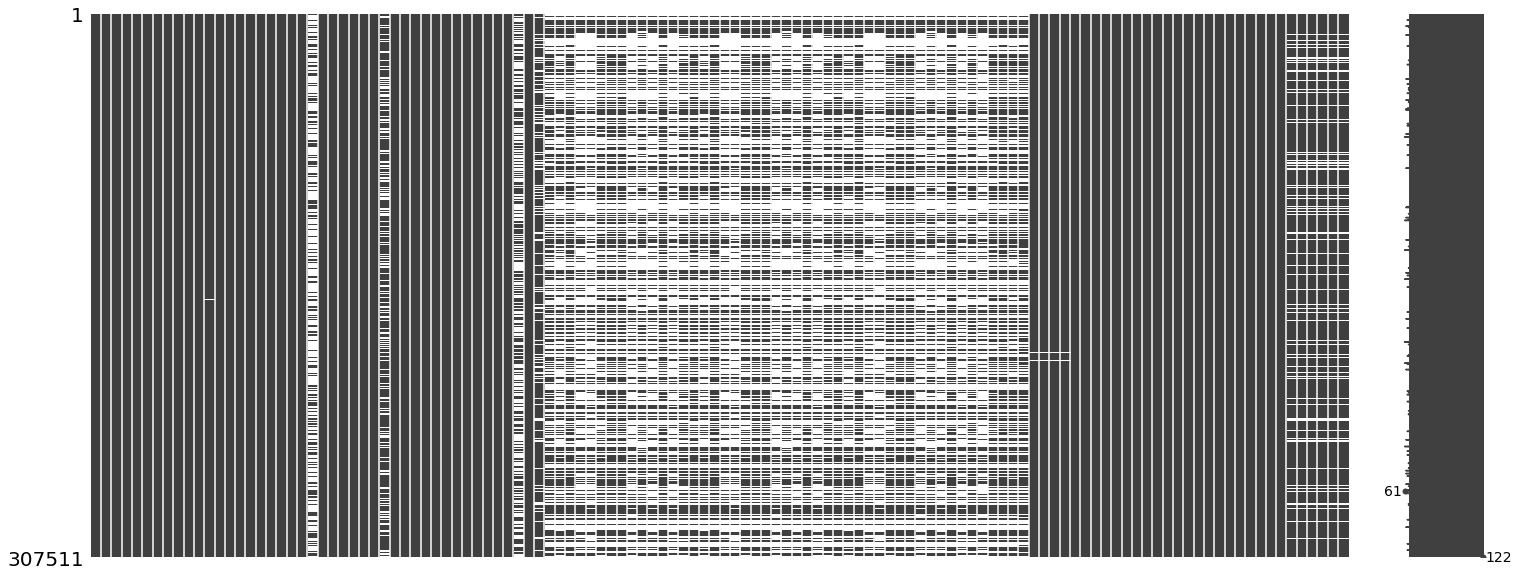

In [ ]:
import missingno as msno
msno.matrix(application_train)

**Data contains lots of null values and need to be clean or replace using Imputation Techniques**

In [ ]:
del msno

**Checking Duplicate Data**

In [ ]:
columns_without_id = [col for col in application_train.columns if col!='SK_ID_CURR']
application_train[application_train.duplicated(subset = columns_without_id, keep=False)]
print('The no. of duplicates in the data:',application_train[application_train.duplicated(subset = columns_without_id, keep=False)].shape[0])
del columns_without_id

The no. of duplicates in the data: 0


**There is No Duplication in data**

#### **Data Visualization**

Type of Loan - Cash or Revolving

In [ ]:
application_train.NAME_CONTRACT_TYPE.value_counts()

Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64

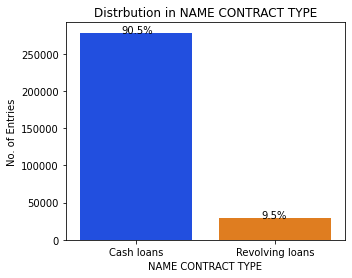

In [ ]:
fig , ax = plt.subplots(figsize=(5,4))
ax = sns.countplot(x = application_train.NAME_CONTRACT_TYPE, data = application_train, order = application_train.NAME_CONTRACT_TYPE.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(application_train.NAME_CONTRACT_TYPE))
    x = i.get_x()+i.get_width()-0.5
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title("Distrbution in NAME CONTRACT TYPE")
plt.xlabel("NAME CONTRACT TYPE")
plt.ylabel("No. of Entries");

**Prefer Cash Loan instead of Revolving Loan**

Default or Not

In [ ]:
application_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

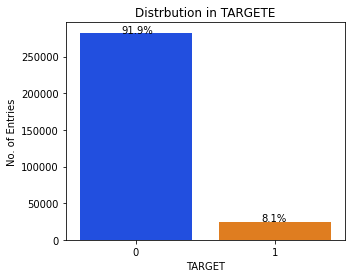

In [ ]:
fig , ax = plt.subplots(figsize=(5,4))
ax = sns.countplot(x = application_train.TARGET, data = application_train, order = application_train.TARGET.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(application_train.TARGET))
    x = i.get_x()+i.get_width()-0.5
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title("Distrbution in TARGETE")
plt.xlabel("TARGET")
plt.ylabel("No. of Entries");

**Data seems highly imblanced and need to be balance**

Gender

In [ ]:
application_train.CODE_GENDER.value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

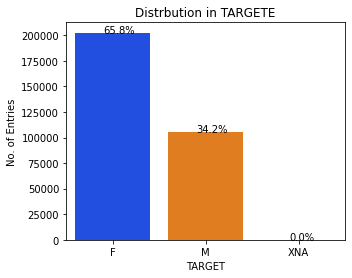

In [ ]:
fig , ax = plt.subplots(figsize=(5,4))
ax = sns.countplot(x = application_train.CODE_GENDER, data = application_train, order = application_train.CODE_GENDER.value_counts().index, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(application_train.CODE_GENDER))
    x = i.get_x()+i.get_width()-0.5
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title("Distrbution in TARGETE")
plt.xlabel("TARGET")
plt.ylabel("No. of Entries");

Gender x Target

Age Distribution

In [ ]:
application_train.DAYS_BIRTH.value_counts()

-13749    43
-13481    42
-18248    41
-10020    41
-15771    40
          ..
-25032     1
-7956      1
-8001      1
-7861      1
-24894     1
Name: DAYS_BIRTH, Length: 17460, dtype: int64

<Figure size 864x360 with 0 Axes>

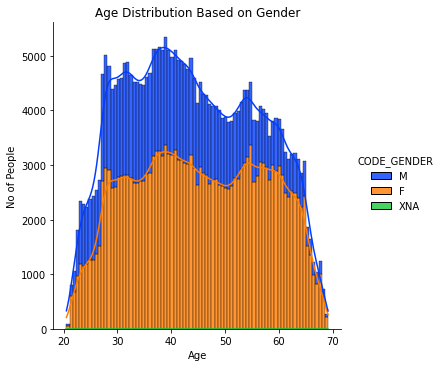

In [ ]:
plt.figure(figsize = (12,5))
sns.displot(x = ((application_train.DAYS_BIRTH)/(-365)), hue = 'CODE_GENDER', kde = True, data = application_train, 
            multiple = 'stack', alpha = 0.8, palette = "bright")
plt.title('Age Distribution Based on Gender')
plt.xlabel("Age")
plt.ylabel("No of People");

Current Children Count

In [ ]:
application_train.CNT_CHILDREN.value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
19         2
12         2
10         2
9          2
8          2
11         1
Name: CNT_CHILDREN, dtype: int64

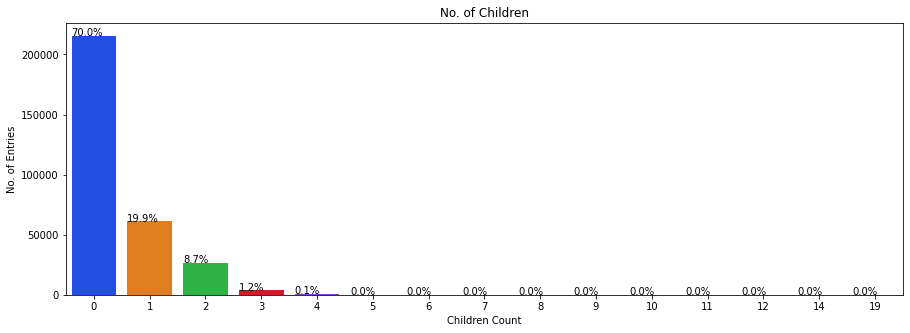

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.CNT_CHILDREN ,data=application_train, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(application_train.CNT_CHILDREN))
    x = i.get_x()+i.get_width()-0.8
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title('No. of Children')
plt.xlabel("Children Count")
plt.ylabel("No. of Entries");

Income Distribution

In [ ]:
application_train.AMT_INCOME_TOTAL.value_counts()

135000.0    35750
112500.0    31019
157500.0    26556
180000.0    24719
90000.0     22483
            ...  
101119.5        1
79425.0         1
101128.5        1
202275.0        1
262174.5        1
Name: AMT_INCOME_TOTAL, Length: 2548, dtype: int64

Credit Amount Distribution

In [ ]:
application_train.AMT_CREDIT.value_counts()

450000.0     9709
675000.0     8877
225000.0     8162
180000.0     7342
270000.0     7241
             ... 
827100.0        1
413442.0        1
1652458.5       1
825853.5        1
2097058.5       1
Name: AMT_CREDIT, Length: 5603, dtype: int64

Type of Suite

In [ ]:
application_train.NAME_TYPE_SUITE.value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

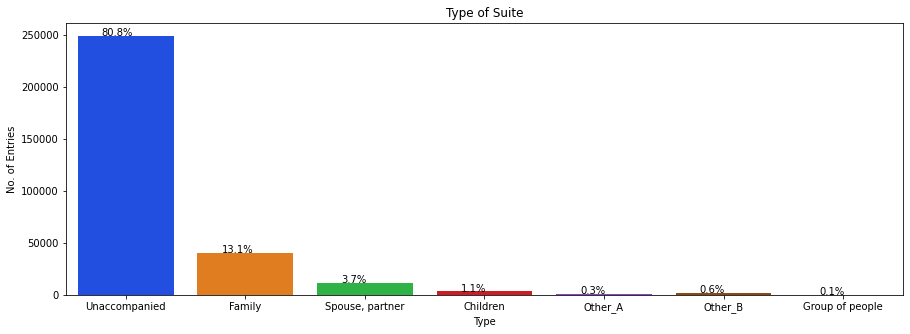

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_TYPE_SUITE ,data=application_train, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(application_train.NAME_TYPE_SUITE))
    x = i.get_x()+i.get_width()-0.6
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title('Type of Suite')
plt.xlabel("Type")
plt.ylabel("No. of Entries");

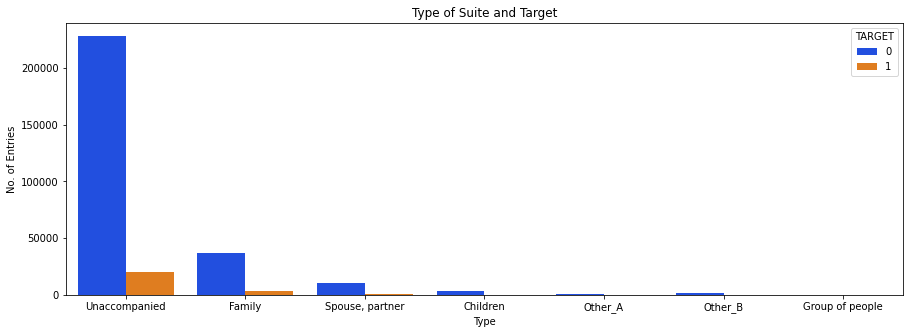

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_TYPE_SUITE, data = application_train, palette = "bright", hue = "TARGET")
plt.title('Type of Suite and Target')
plt.xlabel("Type")
plt.ylabel("No. of Entries");

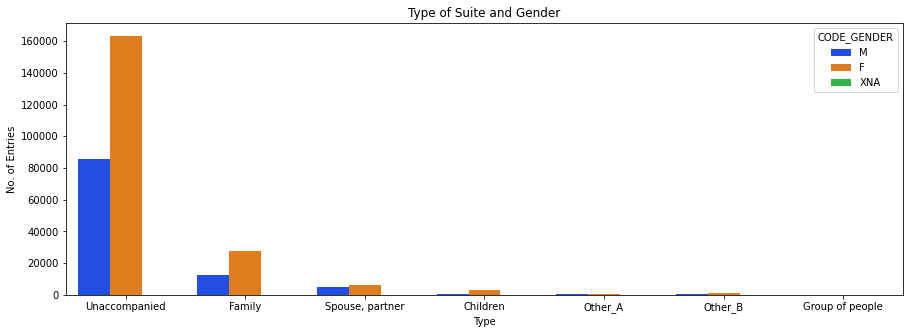

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_TYPE_SUITE, data = application_train, palette = "bright", hue = "CODE_GENDER")
plt.title('Type of Suite and Gender')
plt.xlabel("Type")
plt.ylabel("No. of Entries");

Occupation

In [ ]:
application_train.NAME_INCOME_TYPE .value_counts()

Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtype: int64

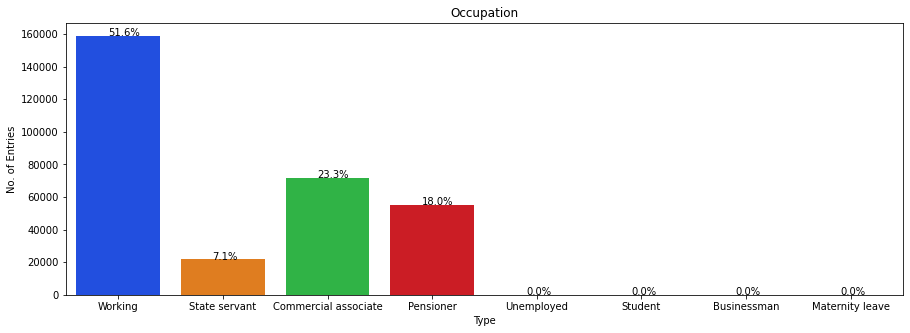

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_INCOME_TYPE ,data=application_train, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(application_train.NAME_INCOME_TYPE))
    x = i.get_x()+i.get_width()-0.5
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title('Occupation')
plt.xlabel("Type")
plt.ylabel("No. of Entries");

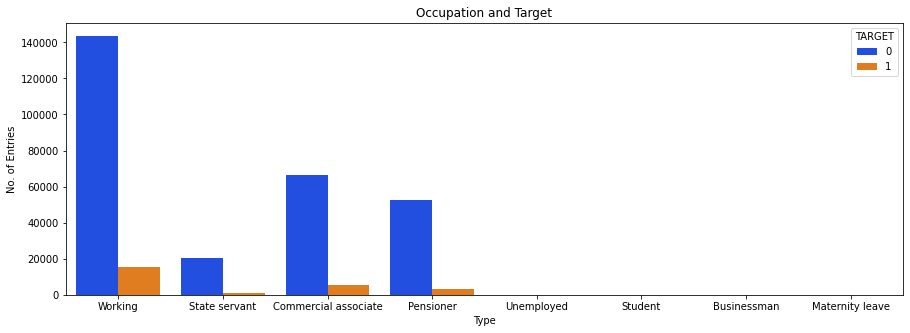

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_INCOME_TYPE, data = application_train, palette = "bright", hue = "TARGET")
plt.title('Occupation and Target')
plt.xlabel("Type")
plt.ylabel("No. of Entries");

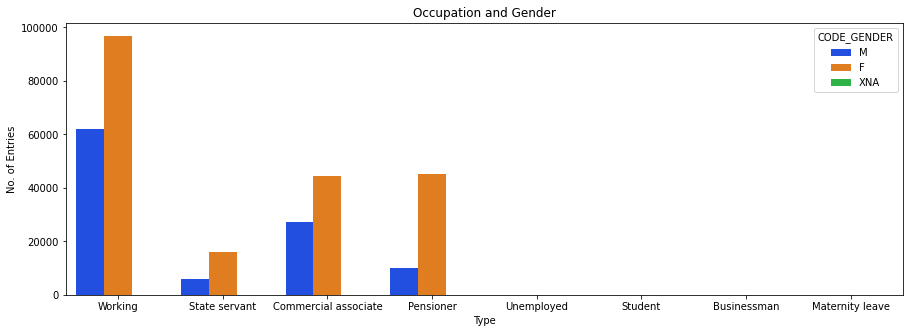

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_INCOME_TYPE, data = application_train, palette = "bright", hue = "CODE_GENDER")
plt.title('Occupation and Gender')
plt.xlabel("Type")
plt.ylabel("No. of Entries");

Time Period of Current Employment

In [ ]:
application_train.DAYS_EMPLOYED.value_counts()

 365243    55374
-200         156
-224         152
-199         151
-230         151
           ...  
-11115         1
-11371         1
-11883         1
-13536         1
-8795          1
Name: DAYS_EMPLOYED, Length: 12574, dtype: int64

<Figure size 864x360 with 0 Axes>

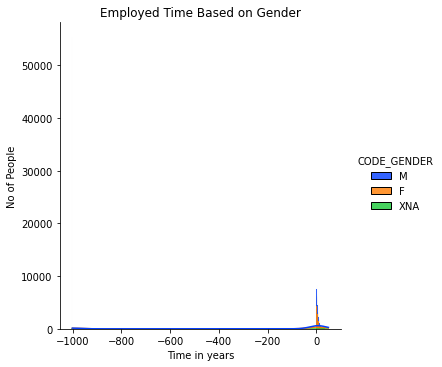

In [ ]:
plt.figure(figsize = (12,5))
sns.displot(x = ((application_train.DAYS_EMPLOYED)/(-365)), hue = 'CODE_GENDER', kde = True, data = application_train, 
            multiple = 'stack', alpha = 0.8, palette = "bright")
plt.title('Employed Time Based on Gender')
plt.xlabel("Time in years")
plt.ylabel("No of People");

FIXXING ERROR IN DAYS EMPLOYED COLUMN

In [ ]:
error = application_train[application_train['DAYS_EMPLOYED'] == 365243]
print('The no of errors are :', len(error))
(error['TARGET'].value_counts()/len(error))*100
del error

The no of errors are : 55374


In [ ]:
# Create an error flag column
application_train['DAYS_EMPLOYED_ERROR'] = application_train["DAYS_EMPLOYED"] == 365243
# Replace the error values with nan
application_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [ ]:
application_train.DAYS_EMPLOYED.value_counts()

-200.0      156
-224.0      152
-230.0      151
-199.0      151
-212.0      150
           ... 
-8868.0       1
-13006.0      1
-10261.0      1
-14079.0      1
-9062.0       1
Name: DAYS_EMPLOYED, Length: 12573, dtype: int64

<Figure size 864x360 with 0 Axes>

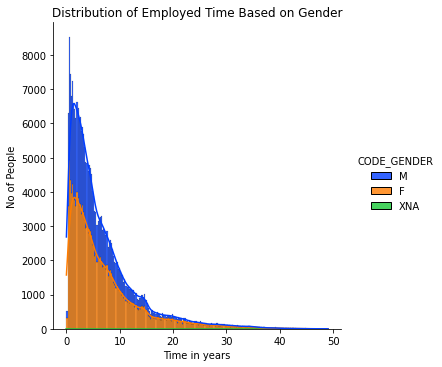

In [ ]:
plt.figure(figsize = (12,5))
sns.displot(x = ((application_train.DAYS_EMPLOYED)/(-365)), hue = 'CODE_GENDER', kde = True, data = application_train, 
            multiple = 'stack', alpha = 0.8, palette = "bright")
plt.title('Distribution of Employed Time Based on Gender')
plt.xlabel("Time in years")
plt.ylabel("No of People");

<Figure size 864x360 with 0 Axes>

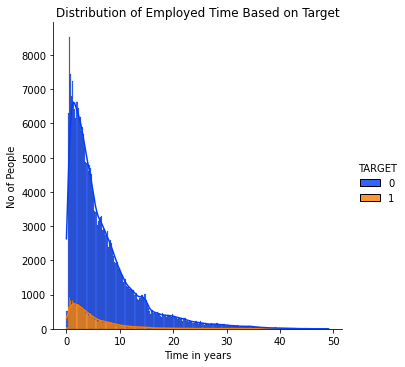

In [ ]:
plt.figure(figsize = (12,5))
sns.displot(x = ((application_train.DAYS_EMPLOYED)/(-365)), hue = 'TARGET', kde = True, data = application_train, 
            multiple = 'stack', alpha = 0.8, palette = "bright")
plt.title('Distribution of Employed Time Based on Target');
plt.xlabel("Time in years");
plt.ylabel("No of People");

Education

In [ ]:
application_train.NAME_EDUCATION_TYPE.value_counts()

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

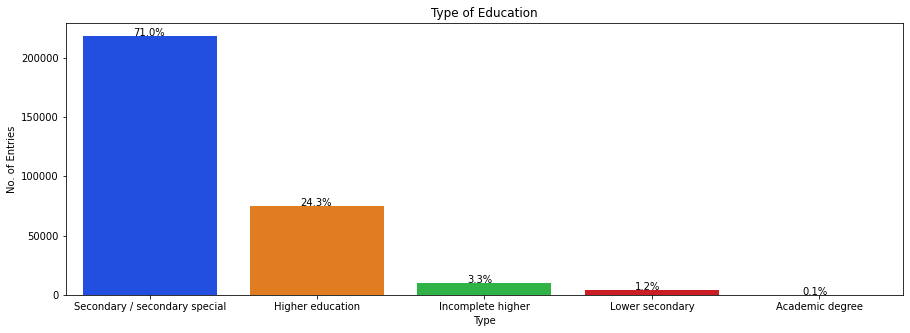

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_EDUCATION_TYPE ,data=application_train, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(application_train.NAME_EDUCATION_TYPE))
    x = i.get_x()+i.get_width()-0.5
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title('Type of Education');
plt.xlabel("Type");
plt.ylabel("No. of Entries");

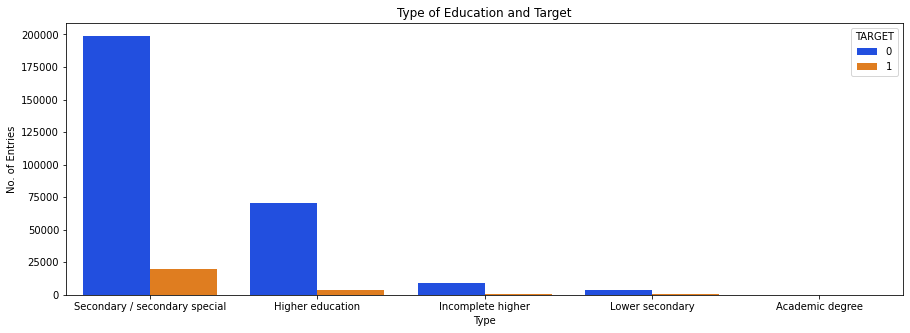

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_EDUCATION_TYPE ,data=application_train, palette = "bright", hue = "TARGET")
plt.title('Type of Education and Target');
plt.xlabel("Type");
plt.ylabel("No. of Entries");

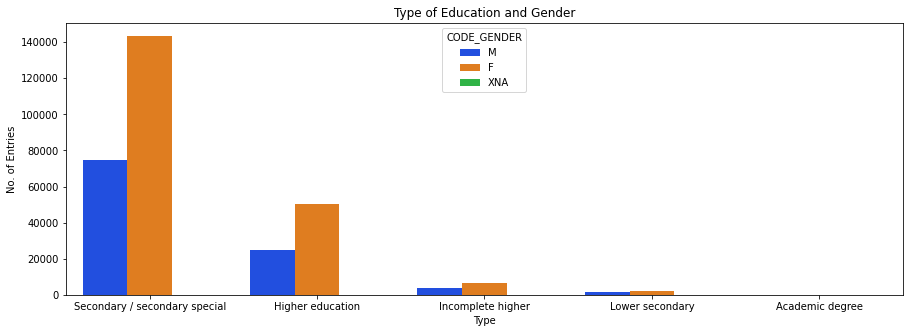

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_EDUCATION_TYPE ,data=application_train, palette = "bright", hue = "CODE_GENDER")
plt.title('Type of Education and Gender');
plt.xlabel("Type");
plt.ylabel("No. of Entries");

Housing Status

In [ ]:
application_train.NAME_HOUSING_TYPE.value_counts()

House / apartment      272868
With parents            14840
Municipal apartment     11183
Rented apartment         4881
Office apartment         2617
Co-op apartment          1122
Name: NAME_HOUSING_TYPE, dtype: int64

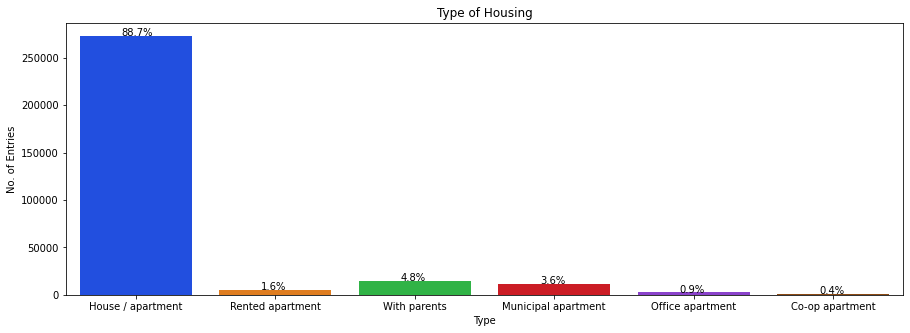

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_HOUSING_TYPE ,data=application_train, palette = "bright")
for i in ax.patches:
    percentage = '{:.1f}%'.format(100*i.get_height()/len(application_train.NAME_HOUSING_TYPE))
    x = i.get_x()+i.get_width()-0.5
    y = i.get_height()
    ax.annotate(percentage, (x, y))
plt.title('Type of Housing');
plt.xlabel("Type");
plt.ylabel("No. of Entries");

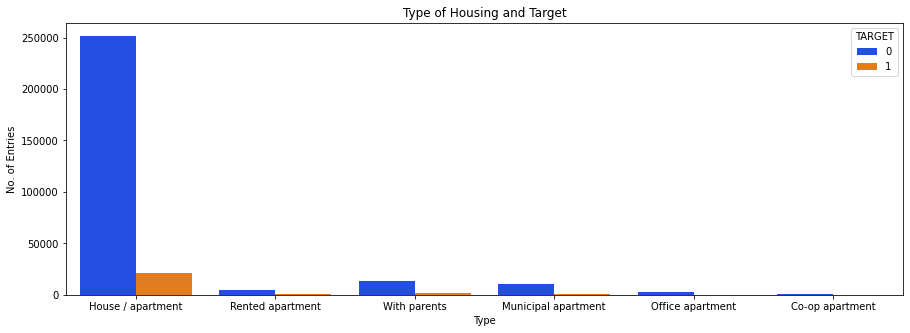

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_HOUSING_TYPE ,data=application_train, palette = "bright", hue = "TARGET")
plt.title('Type of Housing and Target');
plt.xlabel("Type");
plt.ylabel("No. of Entries");

Family Status

In [ ]:
application_train.NAME_FAMILY_STATUS.value_counts()

Married                 196432
Single / not married     45444
Civil marriage           29775
Separated                19770
Widow                    16088
Unknown                      2
Name: NAME_FAMILY_STATUS, dtype: int64

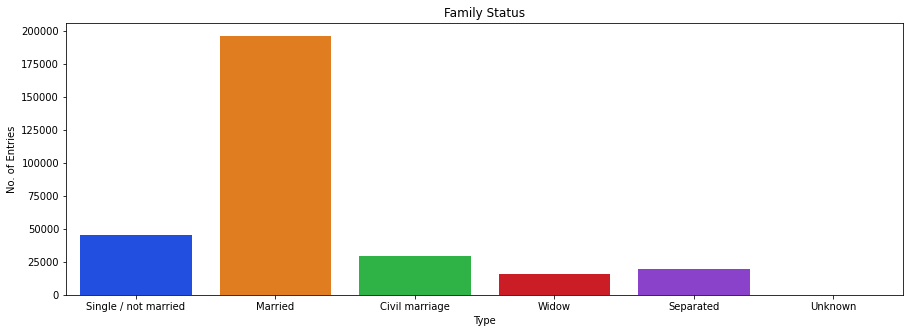

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_FAMILY_STATUS ,data=application_train, palette = "bright")
plt.title('Family Status');
plt.xlabel("Type");
plt.ylabel("No. of Entries");

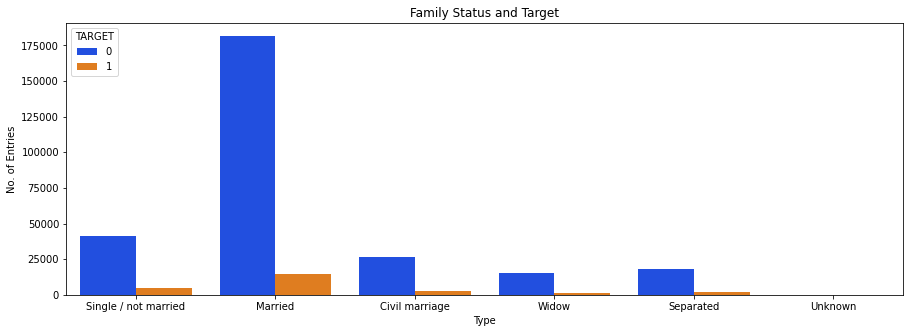

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_FAMILY_STATUS ,data=application_train, palette = "bright", hue = "TARGET")
plt.title('Family Status and Target');
plt.xlabel("Type");
plt.ylabel("No. of Entries");

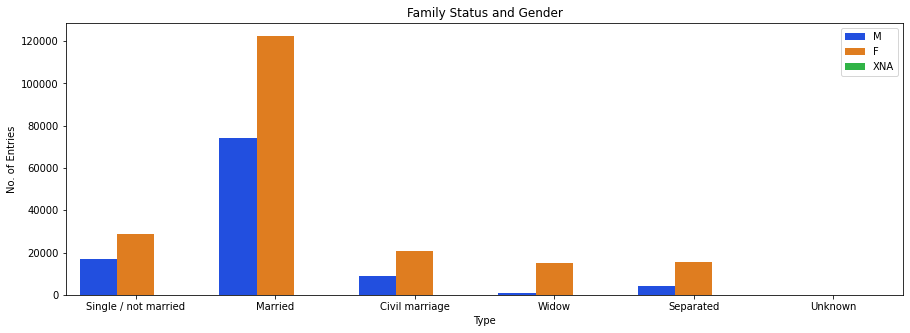

In [ ]:
plt.figure(figsize = (15,5))
ax = sns.countplot(x = application_train.NAME_FAMILY_STATUS ,data=application_train, palette = "bright", hue = "CODE_GENDER")
plt.title('Family Status and Gender');
plt.xlabel("Type");
plt.ylabel("No. of Entries");
plt.legend(loc = "upper right");

## Feature Engineering `Application Train Data`

In [ ]:
application_train['INCOME_GT_CREDIT_FLAG'] = application_train['AMT_INCOME_TOTAL'] > application_train['AMT_CREDIT']
application_train['CREDIT_INCOME_PERCENT'] = application_train['AMT_CREDIT'] / application_train['AMT_INCOME_TOTAL']
application_train['ANNUITY_INCOME_PERCENT'] = application_train['AMT_ANNUITY'] / application_train['AMT_INCOME_TOTAL']
application_train['CREDIT_TERM'] = application_train['AMT_CREDIT'] / application_train['AMT_ANNUITY'] 
application_train['DAYS_EMPLOYED_PERCENT'] = application_train['DAYS_EMPLOYED'] / application_train['DAYS_BIRTH']

## Data Prepration - Merging all 6 Datasets - Key = `SK_ID_CURR`

In [ ]:
count = bureau.isnull().sum().sort_values(ascending=False)
percentage = ((bureau.isnull().sum()/len(bureau)*100)).sort_values(ascending=False)
missing_application = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
missing_application

,Count,Percentage
AMT_ANNUITY,1226791,71.473490
AMT_CREDIT_MAX_OVERDUE,1124488,65.513264
DAYS_ENDDATE_FACT,633653,36.916958
AMT_CREDIT_SUM_LIMIT,591780,34.477415
AMT_CREDIT_SUM_DEBT,257669,15.011932
DAYS_CREDIT_ENDDATE,105553,6.149573
AMT_CREDIT_SUM,13,0.000757
CREDIT_TYPE,0,0.000000
AMT_CREDIT_SUM_OVERDUE,0,0.000000
CNT_CREDIT_PROLONG,0,0.000000


In [ ]:
grp = bureau.drop(['SK_ID_BUREAU'], axis = 1).groupby(by=['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
application_bureau = application_train.merge(grp, on='SK_ID_CURR', how='left')
application_bureau.update(application_bureau[grp.columns].fillna(0))
bureau_categorical = pd.get_dummies(bureau.select_dtypes('object'))
bureau_categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
grp = bureau_categorical.groupby(by = ['SK_ID_CURR']).mean().reset_index()
grp.columns = ['BUREAU_'+column if column !='SK_ID_CURR' else column for column in grp.columns]
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau.update(application_bureau[grp.columns].fillna(0))
grp = bureau.groupby(by = ['SK_ID_CURR'])['SK_ID_BUREAU'].count().reset_index().rename(columns = {'SK_ID_BUREAU': 'BUREAU_LOAN_COUNT'})
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau['BUREAU_LOAN_COUNT'] = application_bureau['BUREAU_LOAN_COUNT'].fillna(0)
grp = bureau[['SK_ID_CURR', 'CREDIT_TYPE']].groupby(by = ['SK_ID_CURR'])['CREDIT_TYPE'].nunique().reset_index().rename(columns={'CREDIT_TYPE': 'BUREAU_LOAN_TYPES'})
application_bureau = application_bureau.merge(grp, on='SK_ID_CURR', how='left')
application_bureau['BUREAU_LOAN_TYPES'] = application_bureau['BUREAU_LOAN_TYPES'].fillna(0)
bureau['AMT_CREDIT_SUM'] = bureau['AMT_CREDIT_SUM'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM': 'TOTAL_CREDIT_SUM'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CREDIT_SUM_DEBT'})
grp1['DEBT_CREDIT_RATIO'] = grp2['TOTAL_CREDIT_SUM_DEBT']/grp1['TOTAL_CREDIT_SUM']
del grp1['TOTAL_CREDIT_SUM']
application_bureau = application_bureau.merge(grp1, on='SK_ID_CURR', how='left')
application_bureau['DEBT_CREDIT_RATIO'] = application_bureau['DEBT_CREDIT_RATIO'].fillna(0)
application_bureau['DEBT_CREDIT_RATIO'] = application_bureau.replace([np.inf, -np.inf], 0)
application_bureau['DEBT_CREDIT_RATIO'] = pd.to_numeric(application_bureau['DEBT_CREDIT_RATIO'], downcast='float')
bureau['AMT_CREDIT_SUM_OVERDUE'] = bureau['AMT_CREDIT_SUM_OVERDUE'].fillna(0)
bureau['AMT_CREDIT_SUM_DEBT'] = bureau['AMT_CREDIT_SUM_DEBT'].fillna(0)
grp1 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_OVERDUE']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_OVERDUE'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_OVERDUE': 'TOTAL_CUSTOMER_OVERDUE'})
grp2 = bureau[['SK_ID_CURR','AMT_CREDIT_SUM_DEBT']].groupby(by=['SK_ID_CURR'])['AMT_CREDIT_SUM_DEBT'].sum().reset_index().rename(columns={'AMT_CREDIT_SUM_DEBT':'TOTAL_CUSTOMER_DEBT'})
grp1['OVERDUE_DEBT_RATIO'] = grp1['TOTAL_CUSTOMER_OVERDUE']/grp2['TOTAL_CUSTOMER_DEBT']
del grp1['TOTAL_CUSTOMER_OVERDUE']
application_bureau = application_bureau.merge(grp1, on='SK_ID_CURR', how='left')
application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau['OVERDUE_DEBT_RATIO'].fillna(0)
application_bureau['OVERDUE_DEBT_RATIO'] = application_bureau.replace([np.inf, -np.inf], 0)
application_bureau['OVERDUE_DEBT_RATIO'] = pd.to_numeric(application_bureau['OVERDUE_DEBT_RATIO'], downcast='float')
del grp, grp2

In [ ]:
count = previous_application.isnull().sum().sort_values(ascending=False)
percentage = ((previous_application.isnull().sum()/len(previous_application)*100)).sort_values(ascending=False)
missing_application = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
missing_application

,Count,Percentage
RATE_INTEREST_PRIVILEGED,1664263,99.643698
RATE_INTEREST_PRIMARY,1664263,99.643698
RATE_DOWN_PAYMENT,895844,53.636480
AMT_DOWN_PAYMENT,895844,53.636480
NAME_TYPE_SUITE,820405,49.119754
DAYS_TERMINATION,673065,40.298129
NFLAG_INSURED_ON_APPROVAL,673065,40.298129
DAYS_FIRST_DRAWING,673065,40.298129
DAYS_FIRST_DUE,673065,40.298129
DAYS_LAST_DUE_1ST_VERSION,673065,40.298129


In [ ]:
grp = previous_application[['SK_ID_CURR','SK_ID_PREV']].groupby(by=['SK_ID_CURR'])['SK_ID_PREV'].count().reset_index().rename(columns={'SK_ID_PREV':'PREV_APP_COUNT'})
application_bureau_prev = application_bureau.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev['PREV_APP_COUNT'] = application_bureau_prev['PREV_APP_COUNT'].fillna(0)
grp = previous_application.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
prev_categorical = pd.get_dummies(previous_application.select_dtypes('object'))
prev_categorical['SK_ID_CURR'] = previous_application['SK_ID_CURR']
prev_categorical.head()
grp = prev_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['PREV_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
del grp

In [ ]:
count = pos_cash_balance.isnull().sum().sort_values(ascending=False)
percentage = ((pos_cash_balance.isnull().sum()/len(pos_cash_balance)*100)).sort_values(ascending=False)
missing_application = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
missing_application

,Count,Percentage
CNT_INSTALMENT_FUTURE,26087,0.260835
CNT_INSTALMENT,26071,0.260675
SK_DPD_DEF,0,0.000000
SK_DPD,0,0.000000
NAME_CONTRACT_STATUS,0,0.000000
MONTHS_BALANCE,0,0.000000
SK_ID_CURR,0,0.000000
SK_ID_PREV,0,0.000000


In [ ]:
grp = pos_cash_balance.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
pos_cash_categorical = pd.get_dummies(pos_cash_balance.select_dtypes('object'))
pos_cash_categorical['SK_ID_CURR'] = pos_cash_balance['SK_ID_CURR']
grp = pos_cash_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['POS_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
del grp

In [ ]:
count = installments_payments.isnull().sum().sort_values(ascending=False)
percentage = ((installments_payments.isnull().sum()/len(installments_payments)*100)).sort_values(ascending=False)
missing_application = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
missing_application

,Count,Percentage
AMT_PAYMENT,2905,0.021352
DAYS_ENTRY_PAYMENT,2905,0.021352
AMT_INSTALMENT,0,0.000000
DAYS_INSTALMENT,0,0.000000
NUM_INSTALMENT_NUMBER,0,0.000000
NUM_INSTALMENT_VERSION,0,0.000000
SK_ID_CURR,0,0.000000
SK_ID_PREV,0,0.000000


In [ ]:
grp = installments_payments.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['INSTA_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
del grp

In [ ]:
count = credit_card_balance.isnull().sum().sort_values(ascending=False)
percentage = ((credit_card_balance.isnull().sum()/len(credit_card_balance)*100)).sort_values(ascending=False)
missing_application = pd.concat([count, percentage], axis=1, keys=['Count','Percentage'])
missing_application

,Count,Percentage
AMT_PAYMENT_CURRENT,767988,19.998063
AMT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_DRAWINGS_OTHER_CURRENT,749816,19.524872
CNT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_ATM_CURRENT,749816,19.524872
AMT_DRAWINGS_POS_CURRENT,749816,19.524872
CNT_INSTALMENT_MATURE_CUM,305236,7.948208
AMT_INST_MIN_REGULARITY,305236,7.948208
SK_DPD_DEF,0,0.000000


In [ ]:
grp = credit_card_balance.drop('SK_ID_PREV', axis =1).groupby(by=['SK_ID_CURR']).mean().reset_index()
prev_columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in grp.columns ]
grp.columns = prev_columns
application_bureau_prev = application_bureau_prev.merge(grp, on =['SK_ID_CURR'], how = 'left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
credit_categorical = pd.get_dummies(credit_card_balance.select_dtypes('object'))
credit_categorical['SK_ID_CURR'] = credit_card_balance['SK_ID_CURR']
grp = credit_categorical.groupby('SK_ID_CURR').mean().reset_index()
grp.columns = ['CREDIT_'+column if column != 'SK_ID_CURR' else column for column in grp.columns]
application_bureau_prev = application_bureau_prev.merge(grp, on=['SK_ID_CURR'], how='left')
application_bureau_prev.update(application_bureau_prev[grp.columns].fillna(0))
del grp

In [ ]:
del application_bureau, bureau, previous_application, pos_cash_balance, installments_payments, credit_card_balance, application_train, bureau_balance

## Data Preprocessing `SimpleImputer` `StandardScaler` & `OneHotEncode`

In [ ]:
data = application_bureau_prev.copy(deep=True)
y = data.pop('TARGET').values
X_train, X_test, y_train, y_test = train_test_split(data.drop(['SK_ID_CURR'],axis=1), y, stratify = y, test_size=0.3, random_state=42)
types = np.array([dt for dt in X_train.dtypes])
all_columns = X_train.columns.values
is_num = types != 'object'
num_cols = all_columns[is_num]
cat_cols = all_columns[~is_num]

#### Imputing Numerical Data `SimpleImputer`

In [ ]:
imputer_num = SimpleImputer(strategy='median')
X_train_num = imputer_num.fit_transform(X_train[num_cols])
X_test_num = imputer_num.transform(X_test[num_cols])
del imputer_num

#### Scaling Numerical Data `StandardScaler`

In [ ]:
scaler_num = StandardScaler()
X_train_num1 = scaler_num.fit_transform(X_train_num)
X_test_num1 = scaler_num.transform(X_test_num)
del scaler_num
del X_train_num, X_test_num

In [ ]:
X_train_num_final = pd.DataFrame(X_train_num1, columns=num_cols)
X_test_num_final = pd.DataFrame(X_test_num1, columns=num_cols)
del X_train_num1, X_test_num1

#### Imputing Categorical Data `SimpleImputer`

In [ ]:
imputer_cat = SimpleImputer(strategy='constant', fill_value='MISSING')
X_train_cat = imputer_cat.fit_transform(X_train[cat_cols])
X_test_cat = imputer_cat.transform(X_test[cat_cols])
del imputer_cat

In [ ]:
X_train_cat1= pd.DataFrame(X_train_cat, columns=cat_cols)
X_test_cat1= pd.DataFrame(X_test_cat, columns=cat_cols)
del X_train_cat, X_test_cat

#### Encoding Categorical Data `OneHotEncoding`

In [ ]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
X_train_cat2 = ohe.fit_transform(X_train_cat1)
X_test_cat2 = ohe.transform(X_test_cat1)
cat_cols_ohe = list(ohe.get_feature_names(input_features=cat_cols))
del ohe
del X_train_cat1, X_test_cat1

In [ ]:
X_train_cat_final = pd.DataFrame(X_train_cat2, columns = cat_cols_ohe)
X_test_cat_final = pd.DataFrame(X_test_cat2, columns = cat_cols_ohe)
del X_train_cat2, X_test_cat2
X_train = pd.concat([X_train_num_final,X_train_cat_final], axis = 1)
X_test = pd.concat([X_test_num_final,X_test_cat_final], axis = 1)
del X_train_num_final,X_train_cat_final,X_test_num_final,X_test_cat_final
del num_cols, cat_cols, is_num, all_columns, types
(unique, counts) = np.unique(y_train, return_counts=True)
print('train : ',counts)
(unique, counts) = np.unique(y_test, return_counts=True)
print('test : ',counts)

train :  [197880  17377]
test :  [84806  7448]


## Class Balancing `RandomOverSampling`

In [ ]:
X_train_cols = X_train.columns
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))
del ros
X_train = pd.DataFrame(X_train, columns=X_train_cols)
del X_train_cols

[(0, 197880), (1, 197880)]


## Feature Selection ` LGBMClassifier`

In [ ]:
fs = lgb.LGBMClassifier(boosting_type='gbdt', max_depth=7, learning_rate=0.01, n_estimators= 2000, class_weight='balanced', subsample=0.9, colsample_bytree= 0.8, n_jobs=-1)
train_features, valid_features, train_y, valid_y = train_test_split(X_train, y_train, test_size = 0.3, random_state = 42)
fs.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], eval_metric = 'auc', verbose = 200)
feature_imp = pd.DataFrame(sorted(zip(fs.feature_importances_, X_train.columns)), columns=['Value','Feature'])
features_df = feature_imp.sort_values(by="Value", ascending=False)
del fs, train_features, valid_features, train_y, valid_y

Training until validation scores don't improve for 100 rounds.
[200]	valid_0's auc: 0.767984	valid_0's binary_logloss: 0.591865
[400]	valid_0's auc: 0.78967	valid_0's binary_logloss: 0.563779
[600]	valid_0's auc: 0.803387	valid_0's binary_logloss: 0.547238
[800]	valid_0's auc: 0.81327	valid_0's binary_logloss: 0.535493
[1000]	valid_0's auc: 0.821523	valid_0's binary_logloss: 0.525932
[1200]	valid_0's auc: 0.828747	valid_0's binary_logloss: 0.517732
[1400]	valid_0's auc: 0.835639	valid_0's binary_logloss: 0.510162
[1600]	valid_0's auc: 0.841987	valid_0's binary_logloss: 0.503159
[1800]	valid_0's auc: 0.847757	valid_0's binary_logloss: 0.496725
[2000]	valid_0's auc: 0.853185	valid_0's binary_logloss: 0.490621
Did not meet early stopping. Best iteration is:
[2000]	valid_0's auc: 0.853185	valid_0's binary_logloss: 0.490621


In [ ]:
selected_features = list(features_df[features_df['Value']>=200]['Feature'])
X_train = X_train[selected_features]
print('X_train',X_train.shape)
X_test = X_test[selected_features]
print('X_test',X_test.shape)
del selected_features, feature_imp, features_df

X_train (395760, 79)
X_test (92254, 79)


## Evaluation Function

In [ ]:
def eval(classifier, X_test, y_test, pred, prob):
    print('----------------------------------------------------')
    cm = confusion_matrix(y_test, pred, labels=[1,0])
    print('Confusion matrix : \n',cm)
    print('----------------------------------------------------')
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn)/(tp + tn + fp + fn)
    precision = (tp / (tp + fp))
    recall = (tp / (tp + fn))
    f1_score = ((2 * precision * recall) / (precision + recall))
    fpr = (fp / (fp + tn))
    fnr = (fn / (fn + tp))
    tnr = (tn / (tn + fp))
    tpr = (tp / (tp + fn))
    npv = (tn / (fn + tn))
    fdr = (fp / (tp + fp))
    print('Accuracy : ', round(accuracy, 3))
    print('Error Rate : ', round((1 - accuracy), 3))
    print('Positive Predictive Value | Precision : ', round(precision, 3))
    print('True Positive Rate | Recall | Sensitivity : ', round(recall,3))
    print('False Positive Rate | Type I error : ', round(fpr,3))  
    print('False Negative Rate | Type II error : ', round(fnr,3))   
    print('True Negative Rate | Specificity : ', round(tnr,3))
    print('----------------------------------------------------')
    print('f1_score : ', round(f1_score, 3))
    print('Log Loss : ',round(log_loss(y_test, pred, eps=1e-15),3))
    print('----------------------------------------------------')
    print('Negative Predictive Value : ', round(npv,3))
    print('False Discovery Rate : ', round(fdr,3))
    print('----------------------------------------------------')
    print('Mean Absolute Error : ',round(mean_absolute_error(y_test, pred),3)) 
    print('Mean Squared Error : ',round(mean_squared_error(y_test, pred, squared=False),3))
    print('----------------------------------------------------')
    #Cross Validation Score (CV=5)
    score=cross_val_score(classifier,X_test,y_test,cv=5)
    print('Coss Validation Score(cv = 5): ',round(score.mean(),3))
    print('----------------------------------------------------')
    #ROC
    logit_roc_auc = roc_auc_score(y_test, pred)
    fpr, tpr, thresholds = roc_curve(y_test, prob[:,1])
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label='(area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    print('----------------------------------------------------')

## Basic Models `Training` & `Evaluation`

#### Model 1 - `LGBMClassifier`

----------------------------------------------------
Confusion matrix : 
 [[ 5121  2327]
 [23141 61665]]
----------------------------------------------------
Accuracy :  0.724
Error Rate :  0.276
Positive Predictive Value | Precision :  0.964
True Positive Rate | Recall | Sensitivity :  0.727
False Positive Rate | Type I error :  0.312
False Negative Rate | Type II error :  0.273
True Negative Rate | Specificity :  0.688
----------------------------------------------------
f1_score :  0.829
Log Loss :  9.535
----------------------------------------------------
Negative Predictive Value :  0.181
False Discovery Rate :  0.036
----------------------------------------------------
Mean Absolute Error :  0.276
Mean Squared Error :  0.525
----------------------------------------------------
Coss Validation Score(cv = 5):  0.919
----------------------------------------------------


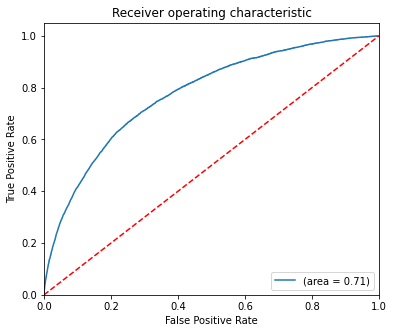

----------------------------------------------------


In [ ]:
lgbm =  lgb.LGBMClassifier(random_state=42, n_jobs=-1)
lgbm.fit(X_train,y_train);
lgbm_pred = lgbm.predict(X_test)
lgbm_prob = lgbm.predict_proba(X_test)
eval(lgbm, X_test, y_test, lgbm_pred, lgbm_prob)

#### Model 2 - `RandomForestClassifier`

----------------------------------------------------
Confusion matrix : 
 [[  142  7306]
 [  165 84641]]
----------------------------------------------------
Accuracy :  0.919
Error Rate :  0.081
Positive Predictive Value | Precision :  0.921
True Positive Rate | Recall | Sensitivity :  0.998
False Positive Rate | Type I error :  0.981
False Negative Rate | Type II error :  0.002
True Negative Rate | Specificity :  0.019
----------------------------------------------------
f1_score :  0.958
Log Loss :  2.797
----------------------------------------------------
Negative Predictive Value :  0.463
False Discovery Rate :  0.079
----------------------------------------------------
Mean Absolute Error :  0.081
Mean Squared Error :  0.285
----------------------------------------------------
Coss Validation Score(cv = 5):  0.919
----------------------------------------------------


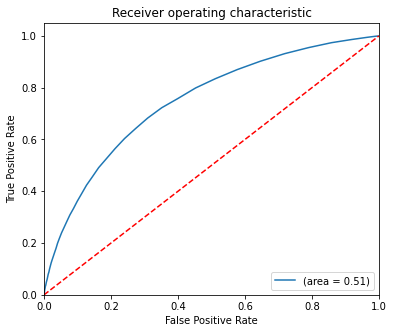

----------------------------------------------------


In [ ]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_prob = rf.predict_proba(X_test)
eval(rf, X_test, y_test, rf_pred, rf_prob)

## Tunned Models

#### Tunned Model 1 - `LGBMClassifier`

----------------------------------------------------
Confusion matrix : 
 [[ 5106  2342]
 [23305 61501]]
----------------------------------------------------
Accuracy :  0.722
Error Rate :  0.278
Positive Predictive Value | Precision :  0.963
True Positive Rate | Recall | Sensitivity :  0.725
False Positive Rate | Type I error :  0.314
False Negative Rate | Type II error :  0.275
True Negative Rate | Specificity :  0.686
----------------------------------------------------
f1_score :  0.827
Log Loss :  9.602
----------------------------------------------------
Negative Predictive Value :  0.18
False Discovery Rate :  0.037
----------------------------------------------------
Mean Absolute Error :  0.278
Mean Squared Error :  0.527
----------------------------------------------------
Coss Validation Score(cv = 5):  0.919
----------------------------------------------------


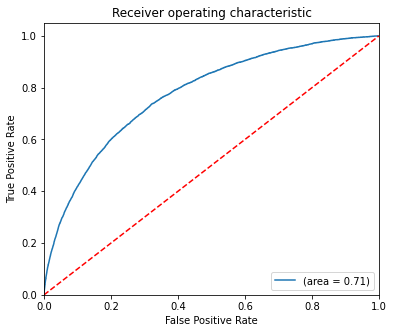

----------------------------------------------------


In [ ]:
lgbm_tunned = lgb.LGBMClassifier(learning_rate=0.10, max_depth=10, min_child_weight=5, gamma=0.3, colsample_bytree=0.5, class_weight='balanced', random_state=42, n_jobs=-1)
lgbm_tunned.fit(X_train,y_train);
lgbm_tunned_pred = lgbm_tunned.predict(X_test)
lgbm_tunned_prob = lgbm_tunned.predict_proba(X_test)
eval(xgb_tunned, X_test, y_test, lgbm_tunned_pred, lgbm_tunned_prob)

#### Tunned Model 2 - `RandomForestClassifier`

----------------------------------------------------
Confusion matrix : 
 [[ 4660  2788]
 [21505 63301]]
----------------------------------------------------
Accuracy :  0.737
Error Rate :  0.263
Positive Predictive Value | Precision :  0.958
True Positive Rate | Recall | Sensitivity :  0.746
False Positive Rate | Type I error :  0.374
False Negative Rate | Type II error :  0.254
True Negative Rate | Specificity :  0.626
----------------------------------------------------
f1_score :  0.839
Log Loss :  9.095
----------------------------------------------------
Negative Predictive Value :  0.178
False Discovery Rate :  0.042
----------------------------------------------------
Mean Absolute Error :  0.263
Mean Squared Error :  0.513
----------------------------------------------------
Coss Validation Score(cv = 5):  0.812
----------------------------------------------------


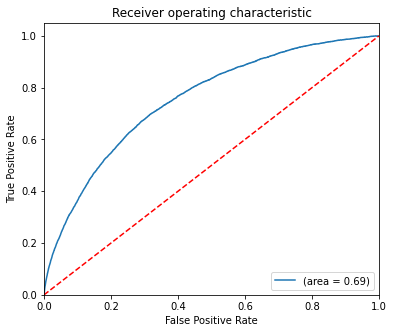

----------------------------------------------------


In [ ]:
rf_tunned = RandomForestClassifier(bootstrap=True, criterion='gini', max_depth=10, max_features=10, min_samples_leaf=8, min_samples_split=15, n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)
rf_tunned.fit(X_train,y_train);
rf_tunned_pred = rf_tunned.predict(X_test)
rf_tunned_prob = rf_tunned.predict_proba(X_test)
eval(rf_tunned, X_test, y_test, rf_tunned_pred, rf_tunned_prob)

## Evaluation Change `Tunned - Base`

#### Function

In [ ]:
def Change_eval(base, tunned, X_test, y_test, pred, prob, tunned_pred, tunned_prob):
    #base
    base_cm = confusion_matrix(y_test, pred, labels=[1,0])
    base_tn, base_fp, base_fn, base_tp = base_cm.ravel()
    base_accuracy = (base_tp + base_tn)/(base_tp + base_tn + base_fp + base_fn)
    base_precision = (base_tp / (base_tp + base_fp))
    base_recall = (base_tp / (base_tp + base_fn))
    base_f1_score = ((2 * base_precision * base_recall) / (base_precision + base_recall))
    base_log_loss = log_loss(y_test, pred, eps=1e-15)
    base_mae = mean_absolute_error(y_test, pred)
    base_mse = mean_squared_error(y_test, pred, squared=False)
    base_fpr = (base_fp / (base_fp + base_tn))
    base_fnr = (base_fn / (base_fn + base_tp))
    base_tnr = (base_tn / (base_tn + base_fp))
    base_tpr = (base_tp / (base_tp + base_fn))
    base_npv = (base_tn / (base_fn + base_tn))
    base_fdr = (base_fp / (base_tp + base_fp))
    #tunned
    tunned_cm = confusion_matrix(y_test, tunned_pred, labels=[1,0])
    tunned_tn, tunned_fp, tunned_fn, tunned_tp = tunned_cm.ravel()
    tunned_accuracy = (tunned_tp + tunned_tn)/(tunned_tp + tunned_tn + tunned_fp + tunned_fn)
    tunned_precision = (tunned_tp / (tunned_tp + tunned_fp))
    tunned_recall = (tunned_tp / (tunned_tp + tunned_fn))
    tunned_f1_score = ((2 * tunned_precision * tunned_recall) / (tunned_precision + tunned_recall))
    tunned_log_loss = log_loss(y_test, tunned_pred, eps=1e-15)
    tunned_mae = mean_absolute_error(y_test, tunned_pred)
    tunned_mse = mean_squared_error(y_test, tunned_pred, squared=False)
    tunned_fpr = (tunned_fp / (tunned_fp + tunned_tn))
    tunned_fnr = (tunned_fn / (tunned_fn + tunned_tp))
    tunned_tnr = (tunned_tn / (tunned_tn + tunned_fp))
    tunned_tpr = (tunned_tp / (tunned_tp + tunned_fn))
    tunned_npv = (tunned_tn / (tunned_fn + tunned_tn))
    tunned_fdr = (tunned_fp / (tunned_tp + tunned_fp))
    #change
    print('----------------------------------------------------')
    print('Accuracy Change : ', round(tunned_accuracy - base_accuracy, 3))
    print('----------------------------------------------------')
    print('Error Rate Change : ', round((1 - (tunned_accuracy - base_accuracy)), 3))
    print('----------------------------------------------------')
    print('Positive Predictive Value | Precision Change : ', round(tunned_precision - base_precision, 3))
    print('----------------------------------------------------')
    print('True Positive Rate | Recall | Sensitivity Change : ', round(tunned_recall - base_recall,3))
    print('----------------------------------------------------')
    print('False Positive Rate | Type I error Change : ', round(tunned_fpr - base_fpr,3))  
    print('----------------------------------------------------')
    print('False Negative Rate | Type II error Change : ', round(tunned_fnr - base_fnr,3))   
    print('----------------------------------------------------')
    print('True Negative Rate | Specificity Change : ', round(tunned_tnr - base_tnr,3))
    print('----------------------------------------------------')
    print('f1_score Change : ', round(tunned_f1_score - base_f1_score, 3))
    print('----------------------------------------------------')
    print('Log Loss Change : ',round(tunned_log_loss - base_log_loss,3))
    print('----------------------------------------------------')
    print('Negative Predictive Value Change : ', round(tunned_npv - base_npv,3))
    print('----------------------------------------------------')
    print('False Discovery Rate Change : ', round(tunned_fdr - base_fdr,3))
    print('----------------------------------------------------')
    print('Mean Absolute Error Change : ',round(tunned_mae - base_mae,3)) 
    print('----------------------------------------------------')
    print('Mean Squared Error Change : ',round(tunned_mse - base_mse,3))
    print('----------------------------------------------------')
    base_score=cross_val_score(base,X_test,y_test,cv=5)
    tunned_score=cross_val_score(tunned,X_test,y_test,cv=5)
    print('Coss Validation Score(cv = 5) Change : ',round(((tunned_score.mean()) - (base_score.mean())),3))
    print('----------------------------------------------------')

### Evaluation Change

#### RandomForestClassifier

In [ ]:
Change_eval(base = rf, tunned = rf_tunned, X_test = X_test, y_test = y_test, pred = rf_pred, prob = rf_prob, tunned_pred = rf_tunned_pred, tunned_prob = rf_tunned_prob)

----------------------------------------------------
Accuracy Change :  -0.182
----------------------------------------------------
Error Rate Change :  1.182
----------------------------------------------------
Positive Predictive Value | Precision Change :  0.037
----------------------------------------------------
True Positive Rate | Recall | Sensitivity Change :  -0.252
----------------------------------------------------
False Positive Rate | Type I error Change :  -0.607
----------------------------------------------------
False Negative Rate | Type II error Change :  0.252
----------------------------------------------------
True Negative Rate | Specificity Change :  0.607
----------------------------------------------------
f1_score Change :  -0.119
----------------------------------------------------
Log Loss Change :  6.298
----------------------------------------------------
Negative Predictive Value Change :  -0.284
----------------------------------------------------
Fals

#### LGBMClassifier

In [ ]:
Change_eval(base = lgbm, tunned = lgbm_tunned, X_test = X_test, y_test = y_test, pred = lgbm_pred, prob = lgbm_prob, tunned_pred = lgbm_tunned_pred, tunned_prob = lgbm_tunned_prob)

----------------------------------------------------
Accuracy Change :  -0.002
----------------------------------------------------
Error Rate Change :  1.002
----------------------------------------------------
Positive Predictive Value | Precision Change :  -0.0
----------------------------------------------------
True Positive Rate | Recall | Sensitivity Change :  -0.002
----------------------------------------------------
False Positive Rate | Type I error Change :  0.002
----------------------------------------------------
False Negative Rate | Type II error Change :  0.002
----------------------------------------------------
True Negative Rate | Specificity Change :  -0.002
----------------------------------------------------
f1_score Change :  -0.001
----------------------------------------------------
Log Loss Change :  0.067
----------------------------------------------------
Negative Predictive Value Change :  -0.001
----------------------------------------------------
False